## Final Project Submission

Please fill out:
* Student name: Daniel Shevelev
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


### Import libraries to perform utility operations:
* convert user-created flat and easy to edit configuration (housed in ./config/user_config.json) to a production json file 'config.json';
* unzip all compressed files and move these unzipped files to "./data" folder from "./zippedData";
* check that every .gz file has a corresponding text file


In [18]:
import os
import sys
import pathlib
import importlib
projectCodePath = os.path.join(pathlib.Path.cwd(),'code')
sys.path.append(projectCodePath)
import utils

### Convert user defined configuration file to production level configuration file

In [19]:
user_config = "./config/user_config.json"
if os.path.exists(user_config):
    utils.convert_user_config_to_json(user_config)
config = utils.load_json_config()

### Use utility functions to decompress data files

In [20]:
### LOAD CONFIG
config = utils.load_json_config()

### CREATE A LIST OF .GZ FILES
zipFileNames = utils.generate_zipfilename_list_from_config(config)
for zipName in zipFileNames:
    txtName = zipName[:-len('.gz')]
    utils.unzip_gz_file(zipName, txtName, config['folders']['data-zip'], config['folders']['data-csv'])

### Check Results of Decompression

In [21]:
zipFiles = [f for f in os.listdir('./zippedData') if os.path.isfile(os.path.join('./zippedData', f))]
txtFiles = [f for f in os.listdir('./data') if os.path.isfile(os.path.join('./data', f))]
for zf, tf in zip(zipFiles, txtFiles):
    print(f"zip file: {zf}\ntxt file: {tf}\n---")

zip file: bom.movie_gross.csv.gz
txt file: bom.movie_gross.csv
---
zip file: imdb.name.basics.csv.gz
txt file: clean.bom.movie_gross.csv
---
zip file: imdb.title.akas.csv.gz
txt file: clean.imdb.title.basics.csv
---
zip file: imdb.title.basics.csv.gz
txt file: clean.imdb.title.ratings.csv
---
zip file: imdb.title.crew.csv.gz
txt file: clean.merge.title.rating.revenue.csv
---
zip file: imdb.title.principals.csv.gz
txt file: clean.tn.movie_budgets.csv
---
zip file: imdb.title.ratings.csv.gz
txt file: imdb.name.basics.csv
---
zip file: rt.movie_info.tsv.gz
txt file: imdb.title.akas.csv
---
zip file: rt.reviews.tsv.gz
txt file: imdb.title.basics.csv
---
zip file: tmdb.movies.csv.gz
txt file: imdb.title.crew.csv
---
zip file: tn.movie_budgets.csv.gz
txt file: imdb.title.principals.csv
---


### Prepare Data for Analysis: Import Libraries

In [22]:
import data_preparation as dataprep

### Prepare Data for Analysis
* Call function `prepare_clean_data(config)` which parses the values of four files (imdb.title.basics.csv, imdb.title.ratings.csv, bom.movie_gross.csv, tn.movie_budgets.csv) based on the rules encoded in functions `prep_imdb_title_basics(config)`, `prep_imdb_title_ratings(config)`, `prep_bom_movie_gross(config)`, and `prep_tn_movie_budgets(config)`.
* Each function writes a file with the prefix "clean.": "clean.imdb.title.basics.csv", "clean.imdb.title.ratings.csv", "clean.bom.movie_gross.csv", and "clean.tn.movie_budgets.csv".

In [23]:
dataprep.prepare_clean_data(config)

### Merge Clean Data
* Function "merge_clean_data" combines all datasets: IMDB title basics, IMDB ratins, BOM revenue, and TN revenue;
* The result is writeen to file "clean.merge.title.rating.revenue.csv";
* The data are loaded for analysis.
* Note a significant reduction of usable data points by data category. 108.6K titles have genre and runtime information. Approximately 28K titles have ratings, and only 4.2K titles have revenue information.

In [24]:
dataprep.merge_clean_data(config)
dfMerged = dataprep.load_merged_clean_data(config)
dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108629 entries, 0 to 108628
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           108629 non-null  object 
 1   title            108629 non-null  object 
 2   year             108629 non-null  uint16 
 3   runtime_minutes  108629 non-null  uint16 
 4   genres           108629 non-null  object 
 5   rating           27962 non-null   float16
 6   numvotes         27962 non-null   float32
 7   domestic_gross   4181 non-null    float64
 8   foreign_gross    4181 non-null    float64
dtypes: float16(1), float32(1), float64(2), object(3), uint16(2)
memory usage: 5.2+ MB


### Which Genres Made the Most Money over the 10 Year Period (2010-2019)?
* Top 3 genres are the same for domestic and foreign audiences:
    - Action, Adventure, Sci-Fi
    - Adventure, Animation, Comedy
    - Action, Adventure, Fantasy
* Action and adventure titles make 4 out of 10 top entries for domestic market and 6 out of 10 entries in foreign markets.
* A title to be successful needs to be built around a story featuring `Action,Adventure` in a Sci-Fi setting, or be an animated feature, or be complemented with comedic or fantasy plot points. Titles which belong to a single genre such as `Comedy`, `Documentary`, or `Drama` are also featured in the top 10 list of genres by gross revenue.

In [25]:
import data_visualization as dataviz

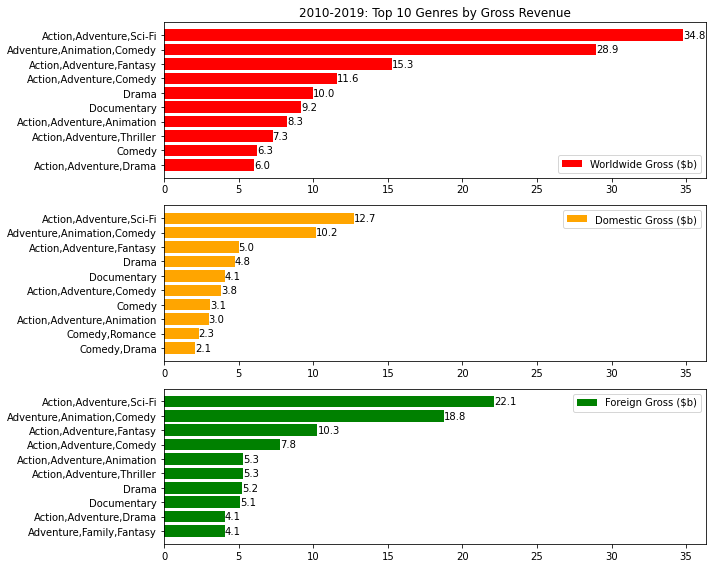

In [26]:
dataviz.bar_chart_top_genres_by_revenue(config)

### Which Genres Made the Most Money on Average per Title over the same 10 Year Period (2010-2019)?
The bar chart below lists top 10 genres by average gross revenue per title. Only genres with more than 10 titles are considered. It is resonable to think that if a genre has less than a title per year on average, it may be too niche for a start-up studio to consider. Potentially, the market may not be ready for another title in this genre.

Besides the mean gross per title, the chart shows historical dispersion of revenue computed as standard deviation of gross revenue across titles within a genre divided by the square root of title count in the same genre (`avg +/- stdev/sqrt(count)`). `title cnt` refers to the total number of titles with recorded revenue in a genre.

#### Recommendation 1
Using the results for average revenue per title, revenue dispersion as a proxy for risk, and title count as a proxy of genre potential and market penetration, **the standing recommendation** is to focus on two genres:
1. **Action, Adventure, Sci-Fi**;
2. **Adventure, Animation, Comedy**


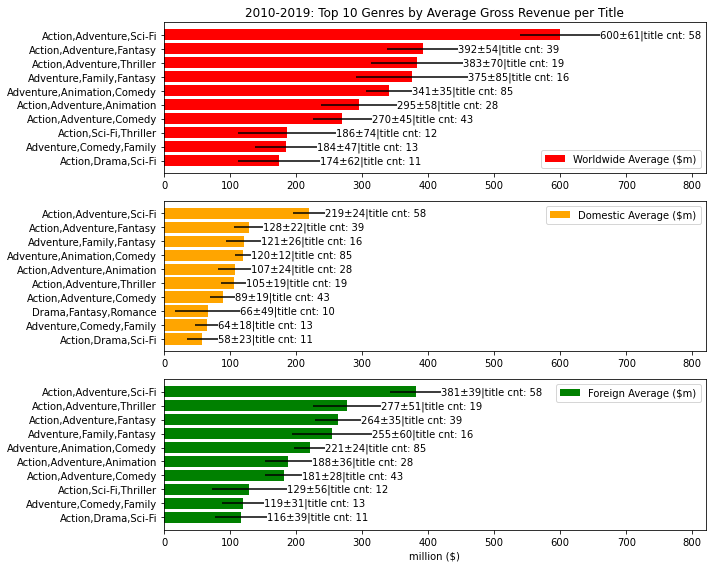

In [27]:
dataviz.bar_chart_top_genres_by_avgrevenue_pertitle(config)

### Which Genres are Most Highly Rated?
* For outcome stability, only titles with `more than 100 votes` and genres with `more than 10 titles` are considered.
* Two rating metrics are computed:
    1. Weighted (by `numvotes`) Average Rating by genre;
    2. Mean Rating across of all titles by genre.
* Both metrics consistently show that rating information point towards viewers' preference for non-fiction genres such as `Documentary`, `History`, `Biography`.
* Composition genres featured in Top 20 are `Biography,Documentary`, `Documentary, History`, `Documentary,Drama`.
#### Recommendation 2
* Focus on non-fiction genre of `Documentary` which can be `biographical`, `historical`, `military`, and/or `dramatic` in nature.
* For example, the genre `Biography,Comedy,Drama` received 2.4 million rating votes; `Biography,Drama,Thiller` - 1.9 million votes; `Action,Adventure,Biography` - 1.0 million votes.

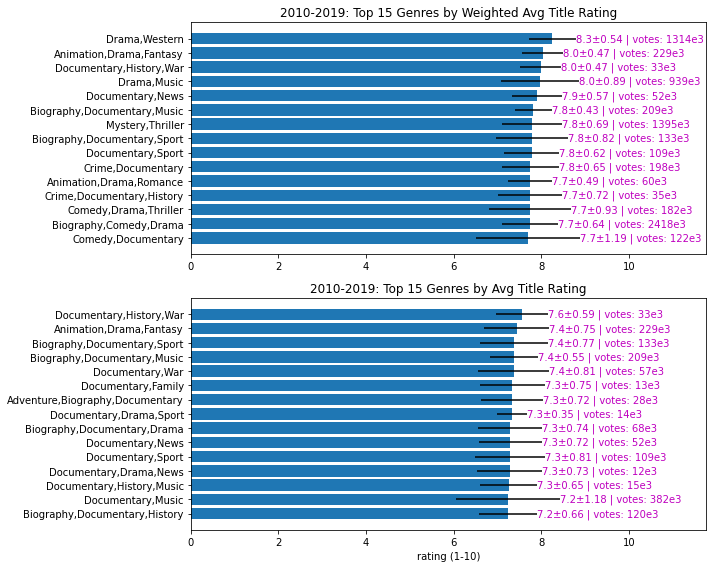

In [28]:
dataviz.bar_chart_top_genres_by_weightedavg_title_rating(config, maxgenres=15)

### Is Rating an Indicator of Revenue?
* Scatter plot will provide a simple evidence whether a higher rating may indicate higher revenue. A scatter plot can be constructed for genre level data and for title level data.
    1. `Scatterplot: Genre Level Data`: x-axis will correspond to rating by genre which have more than 10 titles and each 
        has more than 100 rating votes; y-asix corresponds to total revenue for each genre satisfying 10 title and 100 votes per title requirement.
    2. `Scatterplot: Title Level Data`: `x` axis corresponds to rating of a title, and `y` axis shows the revenue of this title.
    
* If points on a scatterplot coalesce in a straight line or a non-linear curve instead a shapeless cloud of points, then the data show a dependence of revenue on rating. Here, correlation implies causation since high rating serves a proxy for elevated demand.

### The Answer is: "Yes, on average! Yet, A high rating increases earning potential."
* The bar chart below shows that if the average revenue is computed for titles inside a certain rating interval, then the average increases with ratings. Yet, the average revenue is susceptible to outliers, and the variability across title revenue figures increases with rating.
* The title-level data exhibited in the scatterplot are not conclusive. A high rating is not a guarantee of high revenue. Yet, the earning potential of a low rated title is limited. Conversely, the earning potential of a high rated titled is elevated.
#### Recommendation 3
* It is best to avoid a very low rating to not limit the production's earning potential. It can be done by carefully tailoring the film to a target audience and previewing the already shot material with test audiences.

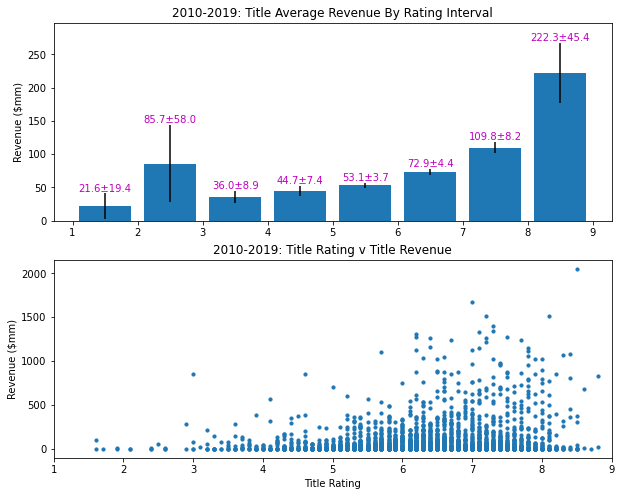

In [29]:
dataviz.barchart_scatterplot_title_rating_and_revenue(config)

#### Recommendation 4
* `Keep it short, under 2.5 hours!` The data show that there no movie titles with revenue records above 3 hours.

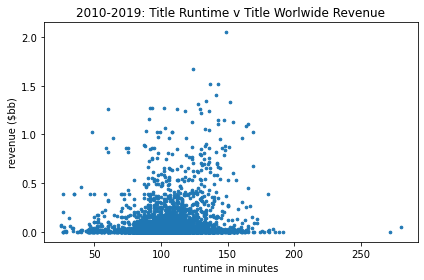

In [30]:
dataviz.scatterplot_title_runtime_and_revenue(config)

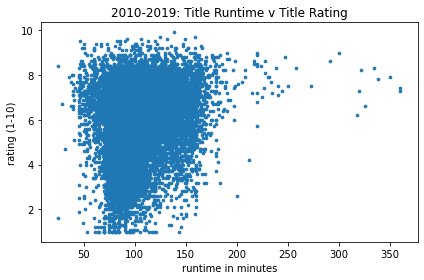

In [31]:
dataviz.scatterplot_title_runtime_and_rating(config)